# Part 4 - "Sleep Delta" Analysis

- "Sleep Delta" is the difference between the previous night's sleep and the reported average amount of sleep. Therefore, a positive delta indicates getting more sleep than usual, whereas a negative delta indicates get less sleep than usual.
- Is a change from the regular amount of sleep associated with cognitive performance?

In [1]:
# Import all required Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

import sys
sys.path.insert(0, '../lib')
import sleep_study_utils as ss

%matplotlib inline
idx = pd.IndexSlice

/home/conor/.virtualenvs/cbs/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Change settings to embed TrueType fonts
# http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Default font size to 8pt
matplotlib.rcParams.update({'font.size': 8})

In [3]:
# List of all columns in the data frame that have scores
score_columns = ss.score_columns() + [score+"_score" for score in ss.COMPOSITE_SCORE_NAMES]
domain_names  = [domain+"_score" for domain in ss.COMPOSITE_SCORE_NAMES[0:-1]]

In [4]:
# Load the final data sample (saved in Part 1)
data = pd.read_pickle('../data/final_sample.pickle.bz2')

In [5]:
# Calculate the effective number of scores being tested. It's not the
# exact number of scores (16) because there is some correlation among
# these measurements (Nyholt 2004)
eff_num_scores = ss.effective_number_of_comparisons(data[score_columns].values)
print("Effective Number of Comparisons: %.03f"%eff_num_scores)

alpha = 0.05
eff_alpha = alpha/eff_num_scores
print("Effective alpha: %.05f"%eff_alpha)

Effective Number of Comparisons: 14.268
Effective alpha: 0.00350


In [6]:
# Calculate the sleep delta
data.loc[:,'sleep_delta'] = data['prev_night_sleep_duration'] - data['typical_sleep_duration']

/home/conor/.virtualenvs/cbs/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


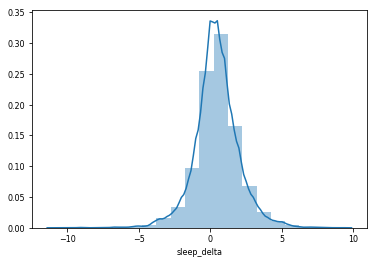

In [7]:
sns.distplot(data['sleep_delta'], bins=20)

In [8]:
data['sleep_delta'].describe()

count    10886.000000
mean         0.450804
std          1.552343
min        -10.750000
25%         -0.500000
50%          0.500000
75%          1.250000
max          9.250000
Name: sleep_delta, dtype: float64

In [9]:
# Shift (offset) continuous predictor variables so that regression 
# intercepts are interpretable. (mean centre variables)
age_offset   = data.loc[:,'age_at_test'].mean()
sleep_offset = data.loc[:,'typical_sleep_duration'].mean()

data.loc[:,'age_at_test'] -= age_offset
data.loc[:,'typical_sleep_duration'] -= sleep_offset
data.loc[:,'prev_night_sleep_duration'] -= sleep_offset

In [10]:
age_regressors   = set(['age_at_test'])
sleep_regressors = set(['np.power(typical_sleep_duration, 2)', 'typical_sleep_duration'])
other_covariates = set(['gender', 'education', 'anxiety', 'depression'])
age_by_sleep     = ss.build_interaction_terms(age_regressors, sleep_regressors)

# Sleep delta will be modelled with a quadratic term, too.
delta_regressors  = set(['np.power(sleep_delta, 2)', 'sleep_delta'])
delta_by_duration = ss.build_interaction_terms(sleep_regressors, delta_regressors)
delta_by_age      = ss.build_interaction_terms(age_regressors, delta_regressors)
full_delta_model  = age_regressors | sleep_regressors | delta_regressors | delta_by_duration | other_covariates
full_delta_model

{'age_at_test',
 'anxiety',
 'depression',
 'education',
 'gender',
 'np.power(sleep_delta, 2)',
 'np.power(typical_sleep_duration, 2)',
 'np.power(typical_sleep_duration, 2):np.power(sleep_delta, 2)',
 'np.power(typical_sleep_duration, 2):sleep_delta',
 'sleep_delta',
 'typical_sleep_duration',
 'typical_sleep_duration:np.power(sleep_delta, 2)',
 'typical_sleep_duration:sleep_delta'}

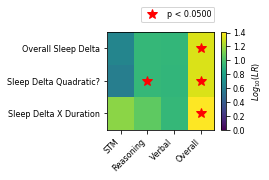

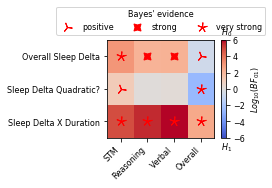

LR         p     p_adj df Delta R^2  \
Overall Sleep Delta    STM        4.38     0.112         1  2  0.000343   
                       Reasoning  8.72    0.0128     0.182  2  0.000703   
                       Verbal     8.62    0.0134     0.192  2  0.000749   
                       Overall    21.2  2.46e-05   0.00035  2   0.00145   
Sleep Delta Quadratic? STM        4.01    0.0451     0.644  1  0.000315   
                       Reasoning  8.72   0.00315     0.045  1  0.000702   
                       Verbal     8.43    0.0037    0.0527  1  0.000732   
                       Overall    21.2  4.08e-06  5.82e-05  1   0.00145   
Sleep Delta X Duration STM        14.5   0.00575    0.0821  4   0.00114   
                       Reasoning  11.5    0.0212     0.303  4  0.000929   
                       Verbal     8.72    0.0686     0.979  4  0.000757   
                       Overall    25.6  3.75e-05  0.000535  4   0.00176   

                                 Cohen f^2     BF_01     BF_10  
Overall Sleep Delta    STM        0.000402  1.22e+03   0.00082  
                       Reasoning  0.000801       139   0.00719  
                       Verbal     0.000792       146   0.00684  
                       Overall     0.00195     0.267      3.74  
Sleep Delta Quadratic? STM        0.000369        14    0.0713  
                       Reasoning  0.000801      1.34     0.749  
                       Verbal     0.000774      1.54     0.648  
                       Overall     0.00195   0.00256       390  
Sleep Delta X Duration STM         0.00134  8.24e+04  1.21e-05  
                       Reasoning   0.00106  3.72e+05  2.69e-06  
                       Verbal     0.000801  1.52e+06  6.59e-07  
                       Overall     0.00236       322   0.00311

In [11]:
# Likelihood Ratio (LR) Tests for different effects
model_comparisons = [
    {'name':'Overall Sleep Delta',
     'h0':ss.build_model_expression(full_delta_model - delta_regressors),
     'h1':ss.build_model_expression(full_delta_model)},
    
    {'name':'Sleep Delta Quadratic?',
     'h0':ss.build_model_expression(full_delta_model - set(['np.power(sleep_delta, 2)'])),
     'h1':ss.build_model_expression(full_delta_model)},
    
    {'name':'Sleep Delta X Duration',
     'h0':ss.build_model_expression(full_delta_model - delta_by_duration),
     'h1':ss.build_model_expression(full_delta_model)},
]

delta_results = ss.compare_models(model_comparisons, data, score_columns[-4:], n_comparisons=eff_num_scores)

figS5a = ss.create_stats_figure(delta_results, 'LR', 'p_adj')
figS5b = ss.create_bayes_factors_figure(delta_results)

figS5a.savefig('../images/FigureS5a.pdf', format='pdf')
figS5b.savefig('../images/FigureS5b.pdf', format='pdf')

pd.set_option('precision', 3)
delta_results.loc[idx[:,ss.COMPOSITE_SCORE_NAMES],:].to_excel('../CSVs/Table3.xlsx')
delta_results.loc[idx[:,ss.COMPOSITE_SCORE_NAMES],:]

In [12]:
# Build a table of estimated parameters (for effects of interest)
# Includes the coefficient value, standard error of the estimate,
# t value, p value, and 95% confidence intervals.
delta_models       = [smf.ols(ss.build_model_expression(full_delta_model)%score, data=data).fit() for score in score_columns[-4:]]
parameters_to_show = list(sleep_regressors)+ list(delta_regressors) + list(delta_by_duration)
parameter_index    = pd.MultiIndex.from_product([parameters_to_show, ss.COMPOSITE_SCORE_NAMES],
                                                names=['parameter', 'score'])
parameter_table    = pd.DataFrame(index=parameter_index, columns=delta_models[-1].summary().tables[1].data[0][1:])
for index, score in enumerate(ss.COMPOSITE_SCORE_NAMES):
    all_parameter_info = np.array(delta_models[index].summary().tables[1].data)
    all_parameter_info = pd.DataFrame(data=all_parameter_info[1:,1:],
                                      index=all_parameter_info[1:,0],
                                      columns=all_parameter_info[0,1:])
    parameter_table.loc[idx[:,score],:] = all_parameter_info.loc[parameters_to_show,:].values
parameter_table.to_excel('../CSVs/TableS10.xlsx')
parameter_table

coef  \
parameter                                          score                   
np.power(typical_sleep_duration, 2)                STM           -0.0076   
                                                   Reasoning     -0.0233   
                                                   Verbal        -0.0189   
                                                   Overall       -0.0274   
typical_sleep_duration                             STM            0.0170   
                                                   Reasoning      0.0355   
                                                   Verbal         0.0455   
                                                   Overall        0.0514   
np.power(sleep_delta, 2)                           STM           -0.0046   
                                                   Reasoning     -0.0066   
                                                   Verbal        -0.0072   
                                                   Overall       -0.0100   
sleep_delta                                        STM            0.0068   
                                                   Reasoning      0.0036   
                                                   Verbal         0.0011   
                                                   Overall        0.0059   
typical_sleep_duration:sleep_delta                 STM            0.0081   
                                                   Reasoning     -0.0078   
                                                   Verbal        -0.0026   
                                                   Overall       -0.0012   
typical_sleep_duration:np.power(sleep_delta, 2)    STM            0.0018   
                                                   Reasoning      0.0012   
                                                   Verbal        -0.0018   
                                                   Overall        0.0010   
np.power(typical_sleep_duration, 2):sleep_delta    STM            0.0039   
                                                   Reasoning      0.0041   
                                                   Verbal      5.733e-05   
                                                   Overall        0.0049   
np.power(typical_sleep_duration, 2):np.power(sl... STM            0.0007   
                                                   Reasoning      0.0001   
                                                   Verbal         0.0003   
                                                   Overall        0.0006   

                                                                std err  \
parameter                                          score                  
np.power(typical_sleep_duration, 2)                STM            0.004   
                                                   Reasoning      0.004   
                                                   Verbal         0.004   
                                                   Overall        0.004   
typical_sleep_duration                             STM            0.008   
                                                   Reasoning      0.008   
                                                   Verbal         0.009   
                                                   Overall        0.008   
np.power(sleep_delta, 2)                           STM            0.002   
                                                   Reasoning      0.002   
                                                   Verbal         0.002   
                                                   Overall        0.002   
sleep_delta                                        STM            0.007   
                                                   Reasoning      0.007   
                                                   Verbal         0.007   
                                                   Overall        0.007   
typical_sleep_duration:sleep_delta                 STM            0.005   
                                                   Reasoni

           Reasoning peak: 1.30 (-0.235-7.377)
             Overall peak: 1.18 (0.249-2.762)


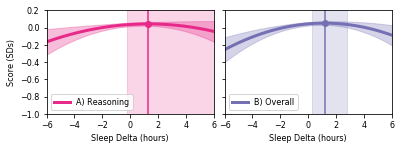

In [13]:
# Re-estimate the models, not including the interaction between sleep delta and typical duration
# Use these to plot the marginal effect of sleep delta, and calculate the peak locations.
estimated_delta_models = [smf.ols(ss.build_model_expression(full_delta_model-delta_by_duration)%score, data=data).fit() for score in score_columns[-4:]]

fig5, axs = plt.subplots(figsize=(5.5,2), nrows=1, ncols=2, sharey=True, sharex=True)
plt_score = {'STM':False, 'Reasoning':True, 'Verbal':False, 'Overall':True}
labels    = ['A) ', 'B) ']
plt_index = 0
for score_index, score_model in enumerate(estimated_delta_models):
    score_color = ss.COMPOSITE_SCORE_COLORS[score_index]
    score_name  = ss.COMPOSITE_SCORE_NAMES[score_index]
    if plt_score[score_name]:
        prediction = ss.get_prediction_and_confidence(score_model, 'sleep_delta').summary_frame()
        vertex     = ss.calculate_parabola_vertex(score_model, 'sleep_delta')
        vertex_CI  = ss.fieller_ci(score_model, 'sleep_delta')
        x_points   = prediction.index
        axs[plt_index].axvline(x=vertex.x, c=score_color)
        axs[plt_index].axvspan(vertex_CI[0], vertex_CI[1], color=score_color, alpha=0.2)
        axs[plt_index].fill_between(x_points, prediction['mean_ci_lower'], prediction['mean_ci_upper'], alpha=0.3, color=score_color)
        axs[plt_index].plot(x_points, prediction['mean'], linewidth=3, color=score_color, label=labels[plt_index]+score_name)
        axs[plt_index].plot(vertex.x, vertex.y, marker='o', c=score_color)
        axs[plt_index].set_xlim([-6,6])
        axs[plt_index].set_ylim([-1,0.2])
        axs[plt_index].set_xlabel('Sleep Delta (hours)')
        axs[plt_index].legend(loc='lower left')
        print('%20s peak: %.02f (%.03f-%.03f)'%(score_name, vertex.x, vertex_CI[0], vertex_CI[1]))
        plt_index += 1
axs[0].set_ylabel('Score (SDs)')
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
fig5.savefig('../images/Figure5.pdf', format='pdf')

In [14]:
# Sleep_offset is the sample mean for typical_sleep_duration
print("Average typical sleep duration = %.03f hours"%sleep_offset)
print("%.03f hours + %.03f hours = %.03f hours"%(sleep_offset, vertex.x, sleep_offset+vertex.x))

Average typical sleep duration = 6.410 hours
6.410 hours + 1.177 hours = 7.586 hours


### For interest, let's break apart the Sleep Delta X Typical Sleep Duration Interaction:

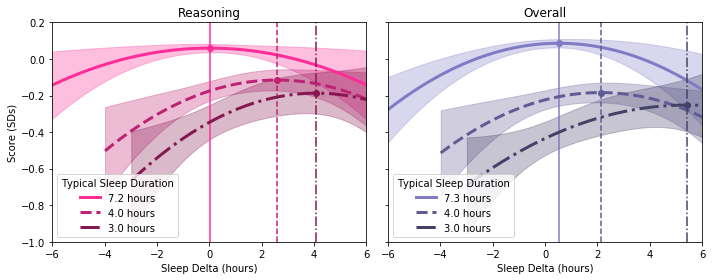

In [15]:
estimated_delta_models = [smf.ols(ss.build_model_expression(full_delta_model)%score, data=data).fit() for score in score_columns[-4:]]
fig, axs = plt.subplots(figsize=(10,4), nrows=1, ncols=2, sharey=True)
sleep_durations = [ None,                  # STM
                    [7.16,4,3]-sleep_offset,   # Reasoning
                    None,                  # Verbal
                    [7.33,4,3]-sleep_offset ] # Overall
shading_steps   = np.array([1.1,0.75,0.7])
linestyle_steps = ['-','--','-.']
plt_index       = 0
for score_index, score_model in enumerate(estimated_delta_models):
    durations = sleep_durations[score_index]
    if durations is not None:
        score_color = ss.COMPOSITE_SCORE_COLORS[score_index]
        score_name  = ss.COMPOSITE_SCORE_NAMES[score_index].capitalize()

        for duration_index, duration in enumerate(durations):
            score_color = list(np.array(score_color)*shading_steps[duration_index])
            prediction = ss.get_prediction_and_confidence(score_model, 'sleep_delta', constants={'typical_sleep_duration':duration}).summary_frame()
            x_points   = np.array(prediction.index)
            show_x     = (duration+sleep_offset+x_points) > 0
            vertex     = ss.calculate_parabola_vertex(score_model, 'sleep_delta', constants={'typical_sleep_duration':duration})
            
            axs[plt_index].fill_between(x_points[show_x], 
                                        prediction['mean_ci_lower'][show_x], prediction['mean_ci_upper'][show_x],
                                        alpha=0.3, color=score_color)
            axs[plt_index].plot(x_points[show_x], prediction['mean'][show_x], 
                                linewidth=3, color=score_color, 
                                linestyle=linestyle_steps[duration_index],
                                label='%.01f hours'%(duration+sleep_offset))
            axs[plt_index].axvline(x=vertex.x, c=score_color, linestyle=linestyle_steps[duration_index])
            axs[plt_index].plot(vertex.x, vertex.y, marker='o', c=score_color)
        
        axs[plt_index].set_xlim([-6,6])
        axs[plt_index].set_ylim([-1,0.2])
        axs[plt_index].set_xlabel('Sleep Delta (hours)')
        axs[plt_index].set_title(score_name)
        axs[plt_index].legend(title='Typical Sleep Duration', loc='lower left')
        plt_index += 1
axs[0].set_ylabel('Score (SDs)')
plt.tight_layout()